In [1]:
from bertopic import BERTopic
import pandas as pd
import numpy as np
from sklearn.feature_extraction.text import CountVectorizer
from re import sub
from sklearn.model_selection import train_test_split
from gensim.models.coherencemodel import CoherenceModel
import gensim.corpora as corpora
import matplotlib.pyplot as plt
from bertopic.vectorizers import ClassTfidfTransformer

In [2]:
#First attempt at bertopics
df = pd.read_csv('reviews.csv')
train, test = train_test_split(df, test_size = 0.2, random_state = 4263, stratify = df['Sentiment'])
train.reset_index(inplace=True)
train['Time'] = pd.to_datetime(df['Time'])
train['Text'] = train['Text'].apply(lambda x: sub("<[^>]+>", "", x).strip())

Pillars for bertopic
Embedding, dimension reduction, clustering, tokenizer, word weighting scheme\
For embedding:\
Transformer\
Gensim\
USE\
spacy\
For dimension reduction:\
UMAP\
PCA\
For clustering:\
HDBSCAN\
K-means (you can choose the number of clusters, can be highly noisy)\
For tokenizer/word weighting\
Count vectorizer (can adjust ngram/stopwords/min df etc)

In [3]:
def get_coherence_score():
    """
    Evaluation metric for model
    """
    documents = pd.DataFrame({"Document": train['Text'],
                            "ID": range(len(train['Text'])),
                            "Topic": topics})
    documents_per_topic = documents.groupby(['Topic'], as_index=False).agg({'Document': ' '.join})
    cleaned_docs = topic_model._preprocess_text(documents_per_topic.Document.values)

    # Extract vectorizer and analyzer from BERTopic
    vectorizer = topic_model.vectorizer_model
    analyzer = vectorizer.build_analyzer()

    # Extract features for Topic Coherence evaluation
    tokens = [analyzer(doc) for doc in cleaned_docs]
    dictionary = corpora.Dictionary(tokens)
    corpus = [dictionary.doc2bow(token) for token in tokens]
    topic_words = [[words for words, _ in topic_model.get_topic(topic)] 
                for topic in range(len(set(topics))-1)]

    # Evaluate
    cm = CoherenceModel(topics=topic_words, 
                                    texts=tokens, 
                                    corpus=corpus,
                                    dictionary=dictionary, 
                                    coherence='c_npmi',
                                    topn=5)
    return cm.get_coherence()

In [30]:
#Start with vector
# Sentence transformer
#What to do with outliers
ctfidf_model = ClassTfidfTransformer(bm25_weighting=True, reduce_frequent_words=True)
vectorizer_model = CountVectorizer(stop_words="english")
topic_model = BERTopic(embedding_model="sentence-transformers/all-MiniLM-L12-v2", ctfidf_model=ctfidf_model,\
                       vectorizer_model=vectorizer_model, calculate_probabilities=False, verbose=True)
topics, probs = topic_model.fit_transform(train['Text'])
original_num_topic = len(topic_model.topic_labels_)
model_results = {'Topics': [],
                 'Coherence': []
                }
c_score = get_coherence_score()
model_results['Topics'].append(original_num_topic)
model_results['Coherence'].append(c_score)
for num_topic in range(original_num_topic-1,15 ,-1):
    topic_model.reduce_topics(train['Text'], nr_topics=num_topic)
    topics = topic_model.topics_
    c_score = get_coherence_score()
    model_results['Topics'].append(num_topic)
    model_results['Coherence'].append(c_score)

2023-03-20 12:24:21,000 - BERTopic - Reduced number of topics from 68 to 66
2023-03-20 12:24:34,531 - BERTopic - Reduced number of topics from 66 to 65
2023-03-20 12:24:48,330 - BERTopic - Reduced number of topics from 65 to 64
2023-03-20 12:25:02,059 - BERTopic - Reduced number of topics from 64 to 63
2023-03-20 12:25:15,831 - BERTopic - Reduced number of topics from 63 to 62
2023-03-20 12:25:29,368 - BERTopic - Reduced number of topics from 62 to 61
2023-03-20 12:25:42,791 - BERTopic - Reduced number of topics from 61 to 60
2023-03-20 12:25:56,254 - BERTopic - Reduced number of topics from 60 to 59
2023-03-20 12:26:09,827 - BERTopic - Reduced number of topics from 59 to 58
2023-03-20 12:26:23,272 - BERTopic - Reduced number of topics from 58 to 57
2023-03-20 12:26:37,291 - BERTopic - Reduced number of topics from 57 to 56
2023-03-20 12:26:50,676 - BERTopic - Reduced number of topics from 56 to 55
2023-03-20 12:27:03,843 - BERTopic - Reduced number of topics from 55 to 54
2023-03-20 1

In [31]:
model_results

{'Topics': [67,
  66,
  65,
  64,
  63,
  62,
  61,
  60,
  59,
  58,
  57,
  56,
  55,
  54,
  53,
  52,
  51,
  50,
  49,
  48,
  47,
  46,
  45,
  44,
  43,
  42,
  41,
  40,
  39,
  38,
  37,
  36,
  35,
  34,
  33,
  32,
  31,
  30,
  29,
  28,
  27,
  26,
  25,
  24,
  23,
  22,
  21,
  20,
  19,
  18,
  17,
  16],
 'Coherence': [0.10052055864098648,
  0.10117894554379463,
  0.09117166009263047,
  0.09401796825483337,
  0.09504546415375327,
  0.09773926127525373,
  0.10713149089675862,
  0.11496658484526619,
  0.11310006374703403,
  0.11163123081369485,
  0.11126648618708165,
  0.1266483720707099,
  0.13000046952342503,
  0.12692542973152932,
  0.12795227192025788,
  0.12943379856697693,
  0.12309303128848853,
  0.12723457440893068,
  0.12536040126830986,
  0.1171844514752504,
  0.11110682296025325,
  0.10979966179556794,
  0.10580619347783558,
  0.10727589734268367,
  0.11302114012228849,
  0.12273008380502094,
  0.11910008723295244,
  0.11691016165719847,
  0.11755678914976307,

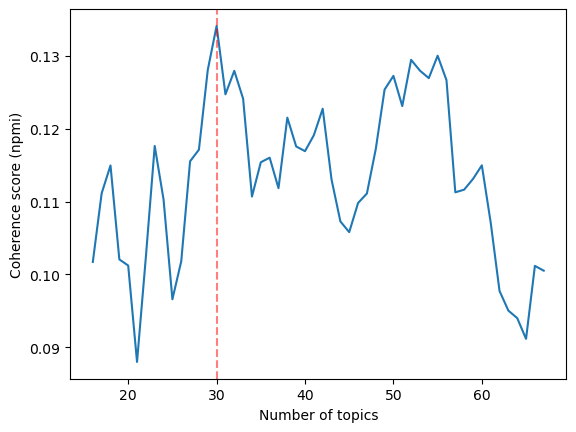

In [38]:
plt.plot(model_results['Topics'], model_results['Coherence'])
plt.axvline(30, color ='r', linestyle ='--', alpha = 0.5)
plt.xlabel('Number of topics')
plt.ylabel('Coherence score (npmi)')
plt.show()

In [ ]:
#OR distilbert-base-nli-stsb-mean-tokens
topic_model = BERTopic(language="english", calculate_probabilities=True, verbose=True)
topics, probs = topic_model.fit_transform(df['Text'])

# Fine-tune topic representations after training BERTopic
vectorizer_model = CountVectorizer(stop_words="english", ngram_range=(1, 3)) #see if need stop words removal
topic_model.update_topics(docs, vectorizer_model=vectorizer_model)

In [39]:
freq = topic_model.get_topic_info()
freq  # Select the most frequent topic

,Topic,Count,Name
0,-1,1130,-1_price_amazon_product_great
1,0,1311,0_chips_bars_snack_sauce
2,1,1027,1_tea_coffee_drink_cup
3,2,218,2_cookies_cookie_cake_pancakes
4,3,213,3_dog_cat_treats_dogs
5,4,131,4_stevia_sugar_syrup_maple
6,5,61,5_licorice_salt_sea_pomegranate
7,6,54,6_baby_earth_stool_jars
8,7,50,7_popcorn_theater_movie_popper
9,8,44,8_00_50_99_pay


In [40]:
topic_model.visualize_topics()

In [ ]:
# The variable probabilities that is returned from transform() or fit_transform() can be used to understand how confident BERTopic is that certain topics can be found in a document.
#Doesnt seem to be working as expected atm, need to debug
# topics, probs = topic_model.transform(df['Text'])
# topic_model.visualize_distribution(probs, min_probability=0.2)

In [41]:
topic_model.visualize_hierarchy(top_n_topics=15)

In [43]:
topic_model.visualize_barchart(top_n_topics=10)

In [23]:
#possible things to do
#merge similar topics manually
topic_model.merge_topics(df['Text'], topics_to_merge=[1,4,5])
#iteratively merge
topic_model.reduce_topics(df['Text'], nr_topics=10)

In [29]:
vectorizer_model = CountVectorizer(stop_words="english", ngram_range=(1, 3), min_df=10) #see if need stop words removal
topic_model.update_topics(train['Text'], vectorizer_model=vectorizer_model)

In [45]:
topics_over_time = topic_model.topics_over_time(docs=train['Text'], 
                                                timestamps=train['Time'], 
                                                global_tuning=True, 
                                                evolution_tuning=True, 
                                                nr_bins=20)

19it [00:00, 24.53it/s]


In [46]:
topic_model.visualize_topics_over_time(topics_over_time, top_n_topics=15)

In [33]:
#Change how labels are generated
topic_labels = topic_model.generate_topic_labels(nr_words = 3, topic_prefix=False, word_length=15, separator='-')
topic_model.set_topic_labels(topic_labels)

#Or to create for specific
topic_model.set_topic_labels({0:"Cold Drink", 1:"Coffee beans"})
topic_model.get_topic_info().head(10)

,Topic,Count,Name,CustomName
0,-1,1269,-1_great_product_good_taste,great-product-good
1,0,347,0_tea_green_iced_drink,Cold Drink
2,1,324,1_coffee_cup_starbucks_beans,Coffee beans
3,2,207,2_product_tastes_taste_great,product-tastes-taste
4,3,167,3_snacks_snack_tasty_fruit,snacks-snack-tasty
5,4,147,4_chips_potato_bag_bbq,chips-potato-bag
6,5,135,5_orange_juice_soda_drink,orange-juice-soda
7,6,134,6_price_grocery_store_amazon,price-grocery-store
8,7,109,7_dog_treats_dogs_treat,dog-treats-dogs
9,8,98,8_nuts_almond_roasted_nut,nuts-almond-roasted


In [36]:
#finding specific topic
topic_model.find_topics('animal', top_n=3)

([12, 7, 17], [0.7597972611987327, 0.7444208026393664, 0.6740989352739281])

In [42]:
topic_model.get_topic(17)

[('china', 0.12490522790589333),
 ('treats', 0.08203824691364132),
 ('dogs', 0.05424114952046814),
 ('dog', 0.0519195313209965),
 ('chicken', 0.04853867168122317),
 ('products', 0.035656979428674934),
 ('usa', 0.03498047359496498),
 ('country', 0.017893434052750193),
 ('sick', 0.017820012181890593),
 ('food', 0.01726687124620462)]

In [25]:
# Save model
topic_model.save("bertopic_model")	

In [28]:
# Load model
topic_model = BERTopic.load("bertopic_model")	